#**Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [ ]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 4s 0us/step


## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [ ]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

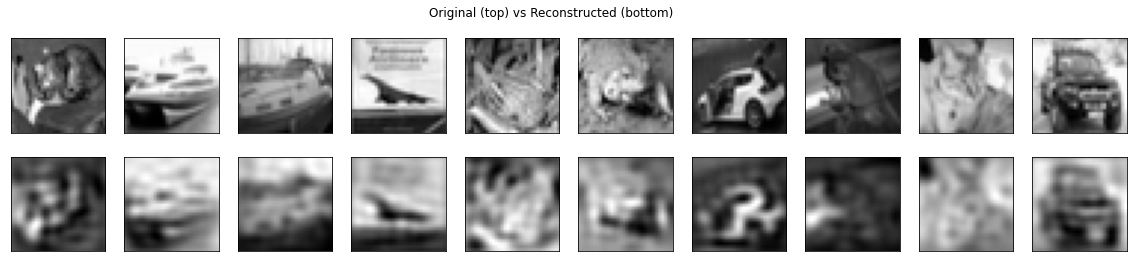

In [ ]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

_Answer:_

ENCONDING_DIM=1
Training mse: 0.04018
Test mse: 0.04014

the top much more clear than the bottom (black-irrecognizable)

ENCONDING_DIM=10
Training mse: 0.01750
Test mse: 0.01761

the top much more clear than the bottom (black-some light white)

ENCONDING_DIM=100
Training mse: 0.00440
Test mse: 0.00443

the top clear the bottom start to be visible but very blur

ENCONDING_DIM=120
Training mse: 0.00372
Test mse: 0.00375

the top clear the bottom start to be visible but very blur

ENCONDING_DIM=150
Training mse: 0.00440
Test mse: 0.00443

the top clear the bottom start to be similar to the upper part the images are recognizable now

ENCONDING_DIM=250
Training mse: 0.00155
Test mse: 0.00159

the top clear the bottom is almost the same that the upper part

ENCONDING_DIM=1000
Training mse: 0.00000
Test mse: 0.00000

the top clear the bottom is the same than the upper part

What I could observe modifying the hyperparameter is that if I reduce it to 1 the reconstructed part becomes totally black and is not representing the images, when I increase the encoding dimension to 1000 this reflects exactly the same representation of the images but is not reducing the dimension of them.

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model.


In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 11ms/step - loss: 0.2048 - val_loss: 0.0324
Epoch 2/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0354 - val_loss: 0.0226
Epoch 3/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0283 - val_loss: 0.0173
Epoch 4/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 5/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0124
Epoch 6/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 7/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 8/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 9/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 10/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.0212
Epoch 11/15
79/79 

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0056 - 509ms/epoch - 2ms/step
Test mse: 0.00555


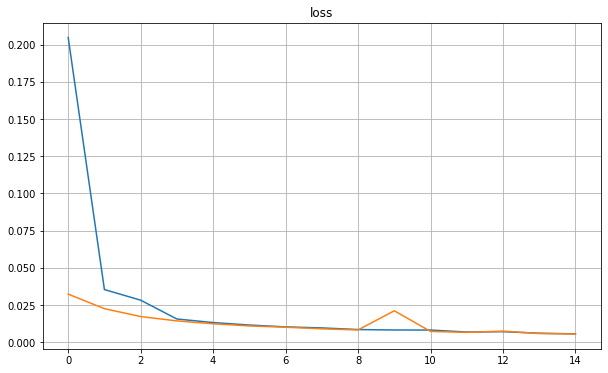

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

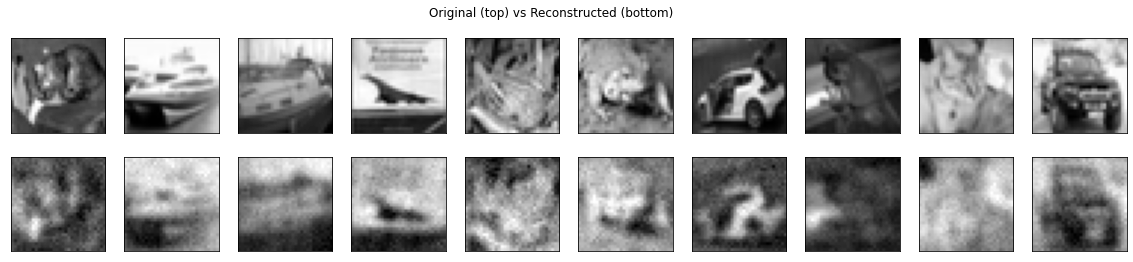

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_
With the shallow linear autoencoder I obtained 0.00555 meanwhile with the SVD 0.00153. The two approaches in the linear case of the autoencoders is similar. Nonetheless we can observe that in this case the SVD achieves a better reconstruction of the images.

##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2.

Insert your code and theoretical discussion into cells immediately below this one.


In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dense_11 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 4s 44ms/step - loss: 0.0352 - val_loss: 0.0225
Epoch 2/15
79/79 [==============================] - 3s 42ms/step - loss: 0.0204 - val_loss: 0.0172
Epoch 3/15
79/79 [==============================] - 3s 42ms/step - loss: 0.0151 - val_loss: 0.0134
Epoch 4/15
79/79 [==============================] - 3s 44ms/step - loss: 0.0140 - val_loss: 0.0120
Epoch 5/15
79/79 [==============================] - 3s 44ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 6/15
79/79 [==============================] - 3s 43ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 7/15
79/79 [==============================] - 3s 42ms/step - loss: 0.0097 - val_loss: 0.0116
Epoch 8/15
79/79 [==============================] - 3s 41ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 9/15
79/79 [==============================] - 3s 41ms/step - loss: 0.0088 - val_loss: 0.0081
Epoch 10/15
79/79 [==============================] - 3s 41ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 11/

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0064 - 880ms/epoch - 3ms/step
Test mse: 0.00640


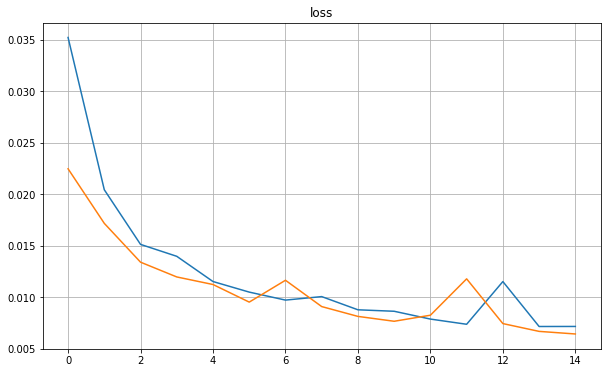

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

# **Comparison of activation functions**

*   Linear

Test mse: 0.03858

*   Non-Linear

* ReLu

Test mse: 0.06027

* Sigmoid

Test mse: 0.00640

In this case we can observe that the MSE is the lowest in the sigmoid non linear function in comparison to the linear case. Comparing the results between the two non linear activation functions we can realize is fewer the MSE in the case of the sigmoid function, that is the main motivation to use it. Nevertheless, in the experiment is better fitted the curve with the ReLu for the enconde and decode layers.


##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM=64

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded1 = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded2 = tf.keras.layers.Dense(64, activation='relu')(encoded1)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded2)
decoded1 = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded2 = tf.keras.layers.Dense(128, activation='relu')(decoded1)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoded2)

autoencoder = tf.keras.models.Model(input_img, decoded) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_12 (Dense)            (None, 128)               131200    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 64)                2112      
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dense_17 (Dense)            (None, 1024)              132

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size= 256, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/100
157/157 [==============================] - 4s 18ms/step - loss: 0.0320 - val_loss: 0.0246
Epoch 2/100
157/157 [==============================] - 3s 17ms/step - loss: 0.0231 - val_loss: 0.0211
Epoch 3/100
157/157 [==============================] - 3s 17ms/step - loss: 0.0199 - val_loss: 0.0196
Epoch 4/100
157/157 [==============================] - 3s 19ms/step - loss: 0.0190 - val_loss: 0.0187
Epoch 5/100
157/157 [==============================] - 3s 17ms/step - loss: 0.0184 - val_loss: 0.0182
Epoch 6/100
157/157 [==============================] - 3s 17ms/step - loss: 0.0178 - val_loss: 0.0179
Epoch 7/100
157/157 [==============================] - 3s 18ms/step - loss: 0.0177 - val_loss: 0.0178
Epoch 8/100
157/157 [==============================] - 3s 17ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 9/100
157/157 [==============================] - 3s 18ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 10/100
157/157 [==============================] - 3s 22ms/step - loss: 0.016

313/313 - 1s - loss: 0.0133 - 714ms/epoch - 2ms/step
test mse: 0.01331


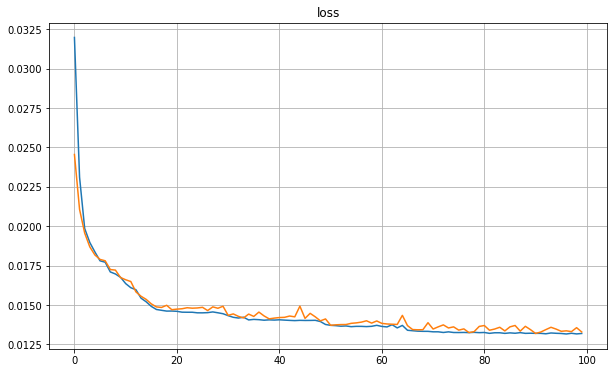

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

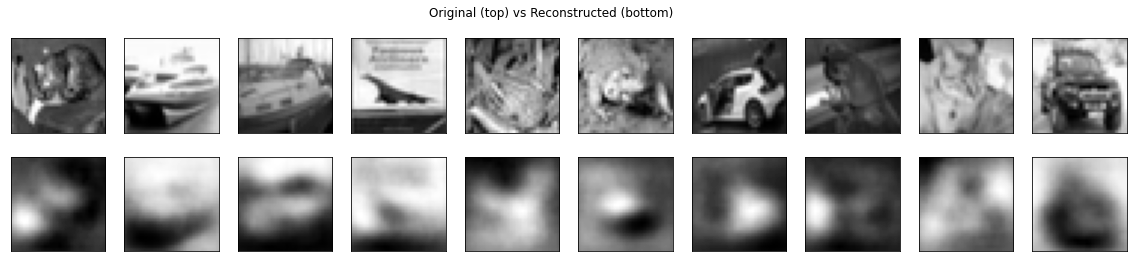

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

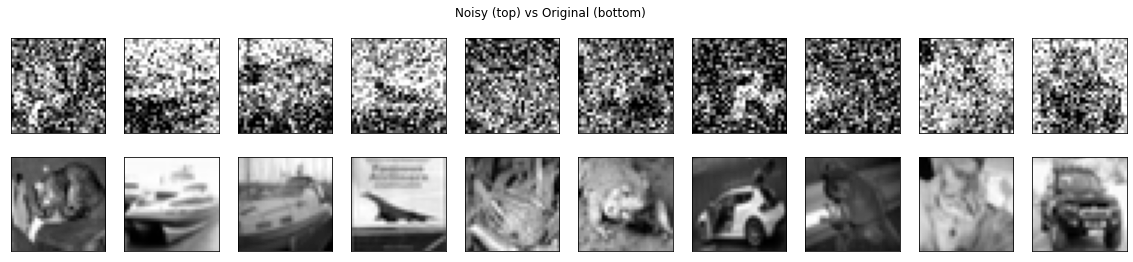

In [ ]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$).

In [ ]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM=64

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse') #[TO COMPLETE]

In [ ]:
autoencoder.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_18 (Dense)            (None, 64)                65600     
                                                                 
 dense_19 (Dense)            (None, 1024)              66560     
                                                                 
Total params: 132,160
Trainable params: 132,160
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid)) #[TO COMPLETE]

Epoch 1/15
79/79 [==============================] - 2s 20ms/step - loss: 0.0391 - val_loss: 0.0275
Epoch 2/15
79/79 [==============================] - 1s 18ms/step - loss: 0.0239 - val_loss: 0.0217
Epoch 3/15
79/79 [==============================] - 1s 18ms/step - loss: 0.0197 - val_loss: 0.0192
Epoch 4/15
79/79 [==============================] - 1s 17ms/step - loss: 0.0168 - val_loss: 0.0157
Epoch 5/15
79/79 [==============================] - 1s 18ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 6/15
79/79 [==============================] - 1s 17ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 7/15
79/79 [==============================] - 1s 17ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 8/15
79/79 [==============================] - 1s 17ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 9/15
79/79 [==============================] - 1s 17ms/step - loss: 0.0134 - val_loss: 0.0120
Epoch 10/15
79/79 [==============================] - 1s 17ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 11/

313/313 - 0s - loss: 0.0147 - 498ms/epoch - 2ms/step
Test mse: 0.01472


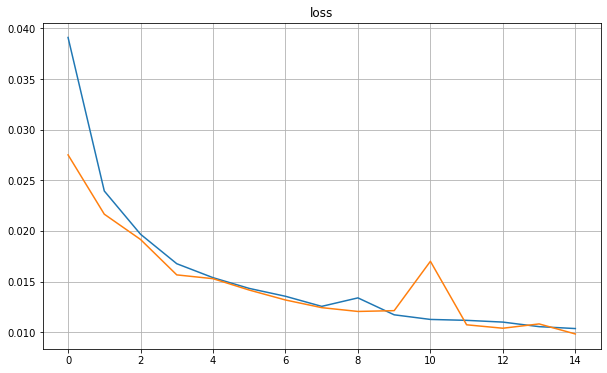

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

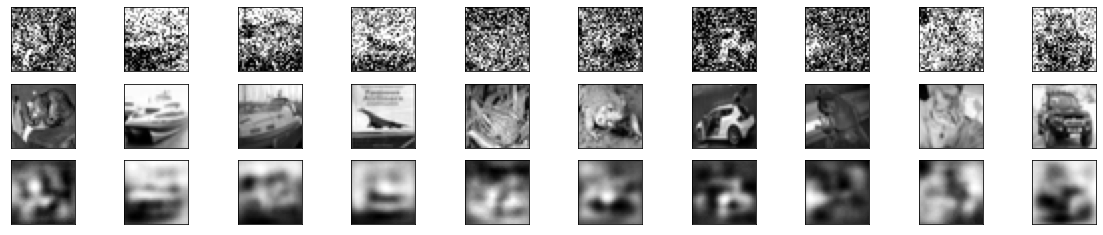

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

1654784/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 90, 50)            7550      
                                                                 
 time_distributed (TimeDistr  (None, 90, 100)          5100      
 ibuted)                                                         
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 9s 94ms/step - loss: 0.1904 - categorical_accuracy: 0.1764 - val_loss: 0.0905 - val_categorical_accuracy: 0.3626
Epoch 2/50
79/79 [==============================] - 7s 92ms/step - loss: 0.0757 - categorical_accuracy: 0.4474 - val_loss: 0.0656 - val_categorical_accuracy: 0.4707
Epoch 3/50
79/79 [==============================] - 7s 91ms/step - loss: 0.0579 - categorical_accuracy: 0.5017 - val_loss: 0.0534 - val_categorical_accuracy: 0.5116
Epoch 4/50
79/79 [==============================] - 7s 91ms/step - loss: 0.0493 - categorical_accuracy: 0.5238 - val_loss: 0.0475 - val_categorical_accuracy: 0.5247
Epoch 5/50
79/79 [==============================] - 7s 91ms/step - loss: 0.0444 - categorical_accuracy: 0.5409 - val_loss: 0.0431 - val_categorical_accuracy: 0.5435
Epoch 6/50
79/79 [==============================] - 8s 97ms/step - loss: 0.0406 - categorical_accuracy: 0.5601 - val_loss: 0.0396 - val_categorical_accuracy: 0.5689
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 1s - loss: 0.0132 - categorical_accuracy: 0.9206 - 830ms/epoch - 21ms/step
categorical_accuracy: 92.06%


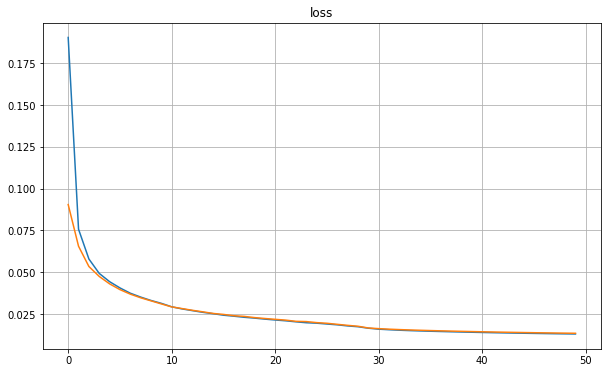

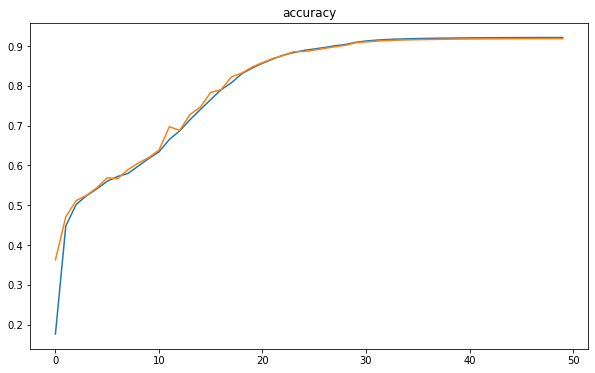

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in way of that time of that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some as <oov> and <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> bad <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than if <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='relu')(inputs)
decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='sigmoid'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 90, 50)            30200     
                                                                 
 time_distributed_3 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 14s 161ms/step - loss: 0.5722 - categorical_accuracy: 0.2602 - val_loss: 0.5334 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 13s 168ms/step - loss: 0.5126 - categorical_accuracy: 0.4710 - val_loss: 0.4746 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] - 13s 160ms/step - loss: 0.4401 - categorical_accuracy: 0.4710 - val_loss: 0.4053 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 12s 155ms/step - loss: 0.3764 - categorical_accuracy: 0.4710 - val_loss: 0.3471 - val_categorical_accuracy: 0.4614
Epoch 5/50
79/79 [==============================] - 13s 161ms/step - loss: 0.3231 - categorical_accuracy: 0.4710 - val_loss: 0.2985 - val_categorical_accuracy: 0.4614
Epoch 6/50
79/79 [==============================] - 12s 155ms/step - loss: 0.2786 - categorical_accuracy: 0.4710 - val_loss: 0.2580 - val_categorical_accuracy: 0.461

40/40 - 1s - loss: 0.0038 - categorical_accuracy: 0.9868 - 839ms/epoch - 21ms/step
categorical_accuracy: 98.68%


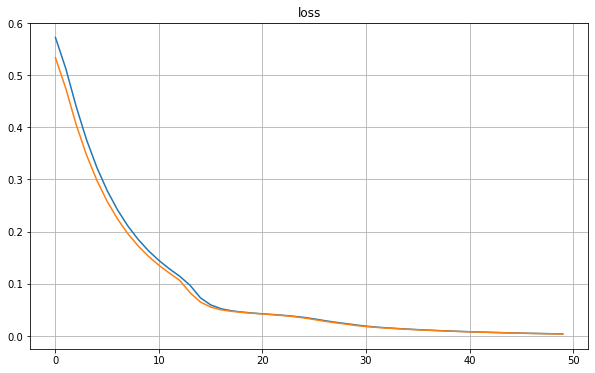

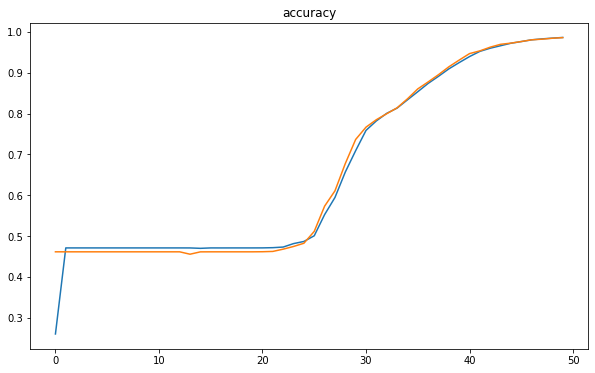

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
<oov> a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


**Comparison between non-linear and linear autoencoder for sequences.**



*   Linear

categorical_accuracy: 92.06%

*   Non-Linear

categorical_accuracy: 98.68%


It is observed that both models have a great accuracy, particularly the non linear model one, in the same fashion as the shallow linear and non-linear autoencoder. The main motivation is because the non linear activation function performed a more accurated approximation to encode the sequece.
To construct the second model I implemented a LSTM layer using ReLu as activation function, and sigmoid to the final layer because we want to be able to classify our outputs into 0 and 1.
